# 📍 Review : Neural Discrete Representation Learning (VQ-VAE)

## 💫 Background Information

### Varitational AutoEnconder (VAE)
- Generative model
- Encoder outputs continuous codes & Prior is static
- Usually have 'Posterior collapse' issues (=latents are ignored when paired with powerful autoregressive decoder)
- Usually use Gaussian distribution (+ autoregressive prior, posterior model, NF, ...)

### Vector Qantisation (VQ) 
- Simple to train
- Not suffer from large variance
- Avoid 'Posterior collapse' issues


### Vector Qantisation Varitational AutoEnconder (VQ-VAE)
- **Goal** : Learining discrete representations (latent variables) without supervison
  - Ex) Discrete representations : Language, Speech, Image
- **Differences** with VAE : Encoder outputs discrete codes & Prior is learnt (not static)
- **Advantage**
  - Train powerful prior
  - Flexibility of discrete distributions (span many dimensions in data space)
  - Generate high quality imgs, videos, speech / speaker conversion / long term structure of env for RL


## 💫 Paper Review

### 1. Introduction
- **Goal** : To achieve a model that conserves important features of data in its latent space while optimising for maximum likelihood
- **Contributions**
  - Simple model, using discrete latents, no posterior collapse, No variance issues
  - Perform well as continuous model in log-likelihood
  - Paired with a powerful prior → high quality on wide variety of applications (ex. speech, video generarion)
  - Learning language through raw speech, without supervision
  

### 2. VQ-VAE
#### Notation
- $z$ : Discrete latent RV (actually : 1D, 2D, 3D, ... latent feature spaces)
- $x$ : Input data
- $p(x)$ : Prior distribution
- $q(z|x)$ : Posterior distribution
- Prior and Posterior distributions are categorical → sampling by index of embedding table 
- $e ∈ R^{K * D}$ : latent embedding space = codebook ($K$ : size of discrete latent space, $D$ : dimension of each $e_i$)
- $e_i ∈ R^D$ : embedding vectors, $i ∈ 1, 2, ..., K$
  - ImageNet : 32x32, CIFAR10 : 8x8x10
  - image의 각 부분을 하나의 embedding index에 대응시켜 표현


#### 1) Discrete Latent variables
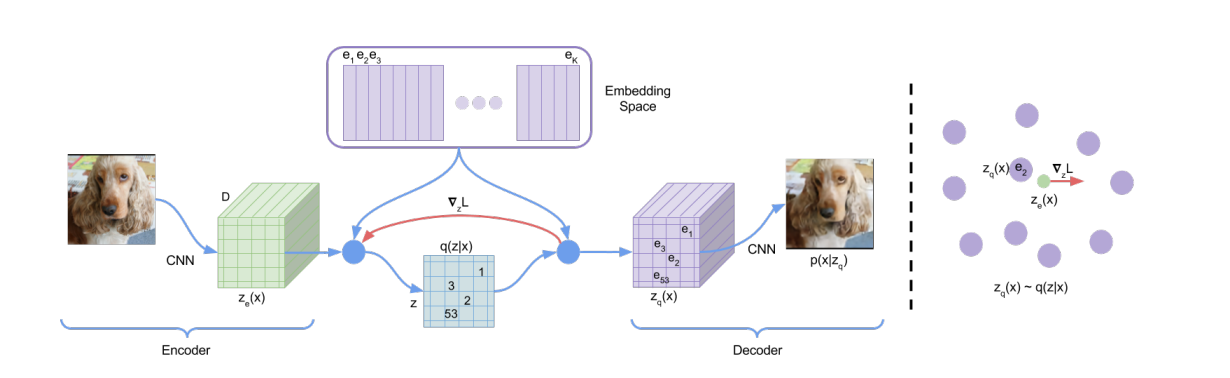

- **(1) Encoder** parameterising a posterior distribution $q(z|x)$ 
  - input : img $x$ → output : $z_e(x)$
  - Eq(1) : calculating $z$ by nearest neighbour look-up using embedding space $e$
  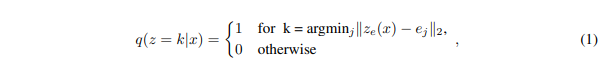
  - View of VAE : log $p(x)$ bounded with ELBO
  - Deterministic $q(z|x)$ & Simple uniform prior → constant KL divergence $log K$

- **(2) Embedding space** $e$

- **(3) Decoder** with $p(x|z)$
  - input : embedding $e_k$ → $z_q(x)$ → output : $p(x|z_q)$
  - Eq(2) : mapping onto nearest element of embedding $e$
  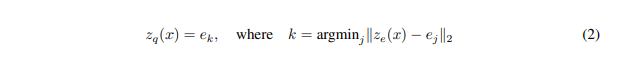
  

#### 2) Learning
- No real gradient in Eq(2)
- Straight-through estimator : Approximate gradient & Copy gradients from decoder input $z_q(x)$ to encoder output $z_e(x)$
- **Forward pass** : nearest embedding $z_q(x)$ is passed to decoder
- **Backward pass** : gradient is passed unaltered to encoder
- Encoder's output and Decoder's input : sharing same $D$ dimensional space → gradients contain information for how encoder has to change its output to lower Reconstruction loss & gradient can push encoder's output to be discretised differently in next forward pass

#### Overall Loss function
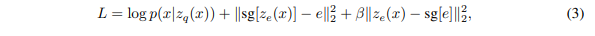

- **Reconstruction loss** : optimizing decoder and encoder 
- **Codebook loss (VQ objective)** : dictionary learning algorithm VQ using L2 error → optimizing embeddings
- **Commitment loss** : dimentionless embedding space 인해 발생하는 '$e_i$ trained slower than encoder parameters 문제' 완화
  - encoder의 weight에만 영향 
- sg : stopgradient operator (identity at forward pass time, non-updated constant)
- $\beta $ = 0.25 (robust)

#### Log-likelihood of complete model $logp(x)$
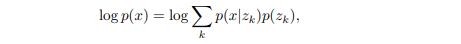

- Decoder $p(x|z)$ is trained with $z = z_q(x)$ from MAP-inference
  - Maximum a Posteriori Probability (MAP) : obtain a point estimate of an unobserved quantity on basis of empirical data
- $logp(x) ≈ logp(x|z_q(x))p(z_q(x))$ →  $logp(x) ≥ logp(x|z_q(x))p(z_q(x))$ by Jensen's inequality

#### 3) Prior distribution over discrete latents $p(z)$
- categorial distribution
- can be made autoregressive by different z in feature map
- Ex) PixelCNN for imgs, WaveNet for raw audio
- While training : constant and uniform
- After training : generate $x$ via ancestral sampling



### 3. Experiments
#### 1) Comparison with continuous variables
- Using same standard VAE arch
  - Encoder : 2 strided conv with stride 2, window size 4x4 / 2 residual 3x3 blocks / 256 hidden units
  - Decoder : 2 residual 3x3 blocks / 2 transposed conv with stride 2, window size 4x4
- Training : Adam optimizer, lr = 23-4, 250,000 steps with batch-size 128 (VIMCO : 50 samples in multi-sample training objective)
- discrete latent 사용해도 continuous latent 사용했을 때와 비교해서 성능이 충분히 좋은지 확인
- Result : **VAE**(continuous variable) : 4.51 bits/dim < **VQ-VAE**(discrete) : 4.67 < **VIMCO**(independent Gaussian or categorical prior) : 5.14
 
#### 2) Images

**(1) Compression**
- ImageNet imgs (x = 128x128x3) → Discrete latent space (z = 32x32x1) with K = 512
- By using purely deconvolutional $p(x|z)$, Reduction = (128x3x8)/(32x32x9) ≈ 42.6배 압축
- Encoder 의해 생성된 z로 powerful prior (PixelCNN) 학습 → speed up & capture global structure

**(2) Reconstruction**
- Discrete latent space (z = 32x32x1) → Reconstructed imgs (128x128x3)
- Only slightly blurrier than original imgs
- (Future work) Possible to use more perceptual loss than MSE 
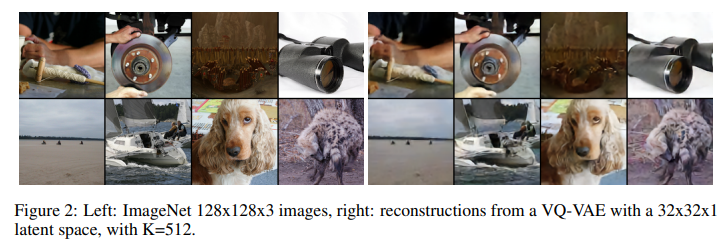

**(3) Training PixelCNN**
- Training PixelCNN prior on discrete latent space (32x32x1)
- Only 1 channel (not 3), Only using spatial masking 
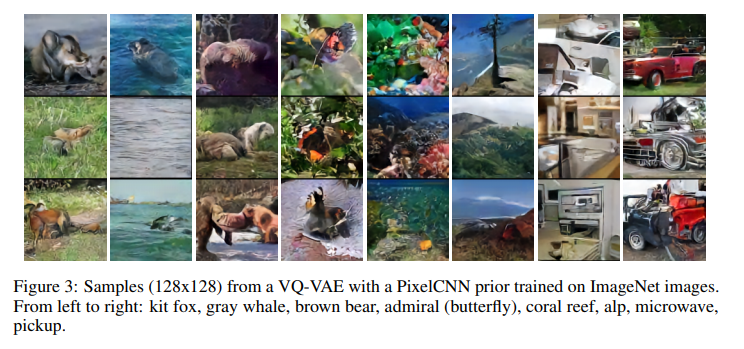

- 84x84x3 frames from DM Lab env
- Training PixelCNN prior on discrete latent space (21x21x1) → Reconstructed samples (128x128)
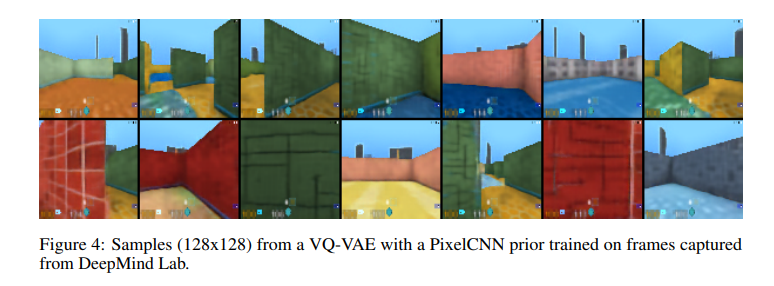

**(4) Final Training PixelCNN**
- Training second VQ-VAE with PixelCNN on discrete latent space (21x21x1)
- Only 3 latent variables at second stage for modeling whole img → Total bits = 3x9 = 27 < float32
- Solution for Posterior collapse problem


#### 3) Audio
**(1) Reconstructed waveform**
- 6 strided conv, stride 2, window-size 4 → 64배 압축
- Latent space (dim=512), one-hot embedding
- Long-term information 보존하도록 Latent space 생성 후 Decoder로 복원
- Result : 내용 변화 X, 운율 변화 O => 언어적 지도 없이 고수준 추상공간 이해 → 중요한 음성 내용만 catch
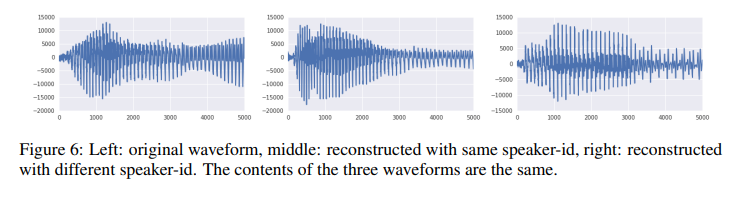


**(2) Unconditional sample**
- Given Latent representation extracted from audio 로 prior을 학습 → Long-term dependency 모델링
- 40960 timestep → 320 latent timestep 압축

**(3) Comparison each latent with GT phoneme-sequence**
- Classification 
- 언어적 지도 없이 음소 정보 터득


#### 4) Video
- DeepMind Lab 
- Given 6 frame  → 나머지 10 frame 이어지게 채움
- Latent space ($z_t$) 상에서만 생성 (Pixel space 이미지 직접 생성 X)
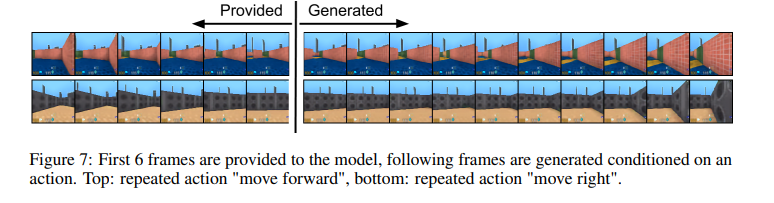


### 4. Conclusion
- VQ + VAE
- Long-term dependency 모델링
- 원본 source를 작은 **discrete latent**로 수십 배 압축
- continuous latent와 성능 필적
- Image, Audio, Video 모델링, 압축, 중요내용 보존, 복원 가능

## 💫 Code Review

### Overall architecture diagram

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

In [ ]:
!pip3 install absl-py>=0.7.1
!pip3 install numpy>=1.16.3
!pip3 install dm-tree>=0.1.1
!pip3 install wrapt>=1.11.1
!pip3 install tabulate>=0.7.5

In [ ]:
!pip install umap

In [ ]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Data

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                                  ]))

In [ ]:
data_variance = np.var(training_data.data / 255.0)

### Vector Quantizer Layer

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

### Encoder & Decoder Architecture
- Based on ResNet

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

### Hyperparameters

In [ ]:
batch_size = 256
num_training_updates = 1500

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

### Load data

In [ ]:
training_loader = DataLoader(training_data, 
                             batch_size=batch_size, 
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=True,
                               pin_memory=True)

### Model

In [ ]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [ ]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

### Train

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

### Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

### Visulalize Reconstructions

In [ ]:
model.eval()

(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

(train_originals, _) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

### Visualize Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

# 📍 Review : Generating Diverse High-Fidelity Images with VQ-VAE-2

### Abstract
- Prior를 강화 → 더 일관성, 현실성 있는 Large-scale image generation
- Prior : PixelCNN + Self-attention → 복원 시 고품질, high coherence

- Model : feed-forward encoder & decoder (Regression model은 latent space에서만 사용) → faster in pixel space
- GAN과 비슷한 성능 + mode collapsing 문제 X

- Lossy compression : 이미지를 30배 작은 discrete latent space에 저장 → 무시해도 되는 정보 모델링에 드는 노력 최소화, 복원력 good
